In [1]:
# ------------------ IMPORTS ------------------
"""
This file contains all the imports that are used in the project.
It is important to mention that it is nessasary to have python 10.3 for ibjpeg.9.dylib on the Mac version M1
"""
import warnings

# Suppress the libjpeg.9.dylib warning from torchvision
warnings.filterwarnings("ignore", message="Failed to load image Python extension")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
from torch.cuda.amp import GradScaler, autocast



In [2]:
# ------------------------- STEP 1: Data Preparation -------------------------
"""
Data Preparation:
This step prepares the training and test datasets for the Pediatric Chest X-ray Pneumonia classification task.
We define two transformation pipelines: `train_transform` for the training set and `test_transform` for the test set.
The training set includes data augmentation to address class imbalance and improve model generalization, while the test set
only includes necessary preprocessing steps to maintain the true data distribution.

Why Augmentation Before Loading:
Data augmentation is defined before loading the dataset because PyTorch's `ImageFolder` applies transformations on-the-fly
as each image is loaded. This approach is memory-efficient, as it avoids storing multiple augmented images, and ensures
dynamic augmentation (e.g., random flips and rotations) is applied differently in each epoch, increasing the effective variety
of the training data. This is particularly important for addressing the imbalance in our dataset (more pneumonia than normal cases),
as it helps the model see varied samples of the minority class (normal) during training.

Training Transformations:
- Grayscale(num_output_channels=1): Converts the image to single-channel grayscale, as X-rays are inherently grayscale.
- Resize((128, 128)): Resizes the image to 128x128 pixels to reduce computational load and speed up training.
- RandomHorizontalFlip(p=0.5): Flips the image horizontally with a 50% probability, mimicking natural left/right symmetry in X-rays.
- RandomVerticalFlip(p=0.1): Flips the image vertically with a 10% probability, simulating rare orientation variations.
- RandomRotation(15): Rotates the image by a random angle between -15 and +15 degrees, adding variety to patient positioning.
- RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)): Applies small translations (5% shift) and scaling (5% zoom in/out)
  to simulate minor positional variations in X-ray imaging.
- ToTensor(): Converts the image to a PyTorch tensor with shape (1, H, W).
- Normalize(mean=[0.5], std=[0.5]): Normalizes the image to have a mean of 0.5 and standard deviation of 0.5, ensuring consistent input
  values for the model.

Test Transformations:
- Grayscale(num_output_channels=1): Converts the image to single-channel grayscale.
- Resize((128, 128)): Resizes the image to 128x128 pixels for consistency with the training set.
- ToTensor(): Converts the image to a PyTorch tensor.
- Normalize(mean=[0.5], std=[0.5]): Normalizes the image to match the training set’s input distribution.
No augmentation is applied to the test set to preserve the true data distribution for evaluation.
"""

# Define data augmentation for training (reasonable for X-rays, addresses imbalance)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure single-channel grayscale
    transforms.Resize((128, 128)),  # Smaller size for speed
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal mirroring
    transforms.RandomVerticalFlip(p=0.1),  # Small chance of vertical flip
    transforms.RandomRotation(15),  # Increased rotation for more variety
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Small translations and scaling
    transforms.ToTensor(),  # Converts to (1, H, W)
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for 1 channel
])

# Test transform (no augmentation, only resizing and normalization)
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='/Users/meggie/Documents/ZHAW/Xray/Pediatric Chest X-ray Pneumonia/train',
    transform=train_transform
)
test_dataset = datasets.ImageFolder(
    root='/Users/meggie/Documents/ZHAW/Xray/Pediatric Chest X-ray Pneumonia/test',
    transform=test_transform
)

# Print dataset statistics to understand the data distribution
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print("Train class distribution:", Counter([label for _, label in train_dataset]))
print("Test class distribution:", Counter([label for _, label in test_dataset]))

# Compute class weights to handle the imbalanced dataset
# Class weights are calculated as total_samples / (num_classes * class_count) to give higher weight to the minority class
labels = [label for _, label in train_dataset]
class_counts = Counter(labels)
total_samples = len(labels)
class_weights = torch.tensor([total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))], dtype=torch.float)
print(f"Class weights (Normal, Pneumonia): {class_weights.tolist()}")

# Compute pos_weight for BCEWithLogitsLoss to further balance the loss function
# pos_weight is the ratio of the weight for the negative class (normal) to the positive class (pneumonia)
pos_weight = torch.tensor([class_weights[0] / class_weights[1]], dtype=torch.float)
print(f"pos_weight for BCEWithLogitsLoss: {pos_weight.item()}")

Train Dataset Size: 5232
Test Dataset Size: 624
Train class distribution: Counter({1: 3883, 0: 1349})
Test class distribution: Counter({1: 390, 0: 234})
Class weights (Normal, Pneumonia): [1.9392142295837402, 0.6737058758735657]
pos_weight for BCEWithLogitsLoss: 2.8784284591674805


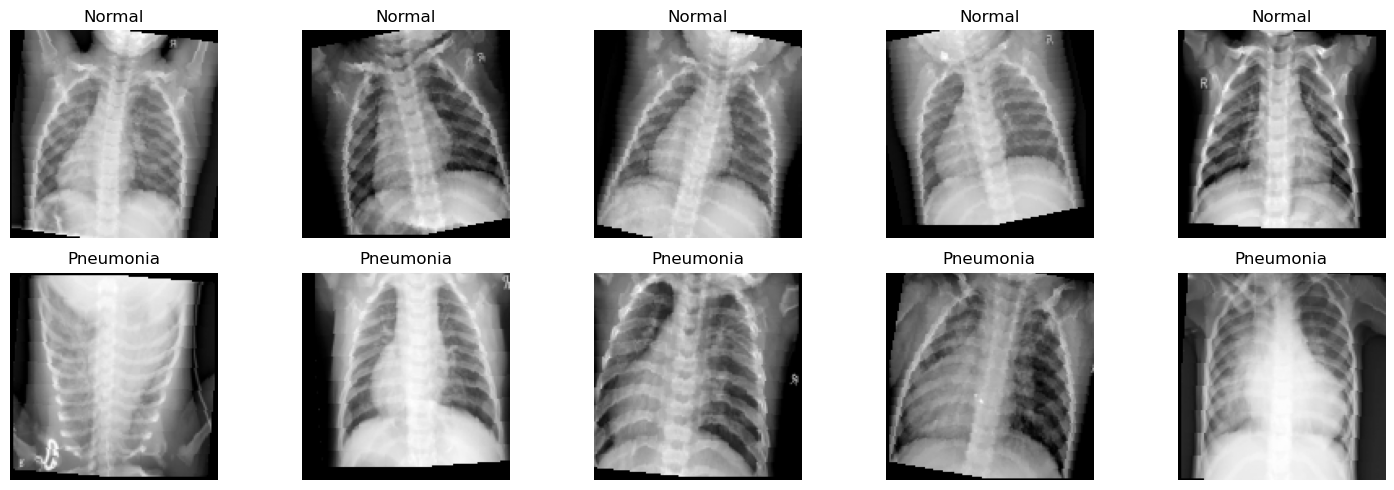

In [3]:
# ------------------------- STEP 2: Display Samples -------------------------

def display_samples(dataset, num_samples=5):
    normal_count = 0
    pneumonia_count = 0
    class_names = dataset.classes  # ['NORMAL', 'PNEUMONIA']

    plt.figure(figsize=(15, 5))

    for i in range(len(dataset)):
        image, label = dataset[i]
        # Denormalize the image for visualization
        image = image * 0.5 + 0.5  # Reverse normalization to [0, 1]
        image = image.numpy().squeeze()  # Shape: (H, W), single channel

        if label == 0 and normal_count < num_samples:
            plt.subplot(2, num_samples, normal_count + 1)
            plt.imshow(image, cmap='gray')
            plt.title('Normal')
            plt.axis('off')
            normal_count += 1

        elif label == 1 and pneumonia_count < num_samples:
            plt.subplot(2, num_samples, num_samples + pneumonia_count + 1)
            plt.imshow(image, cmap='gray')
            plt.title('Pneumonia')
            plt.axis('off')
            pneumonia_count += 1

        if normal_count >= num_samples and pneumonia_count >= num_samples:
            break

    plt.tight_layout()
    plt.show()

display_samples(train_dataset, num_samples=5)



In [5]:
# ------------------------- STEP 3: Define Models -------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # Adjusted for 1 channel
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Adjusted for 128x128 input
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def get_resnet_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjusted for 1 channel
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model



Using device: cpu


In [6]:
# ------------------------- STEP 4: Data Split Function -------------------------

def create_data_loaders(split_type):
    if split_type == '70/30':
        # 70% train, 30% test (no validation set)
        train_size = int(0.7 * len(train_dataset))
        val_size = 0
        test_size = len(train_dataset) - train_size
        train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size])
    elif split_type == '60/20/20':
        # 60% train, 20% val, 20% test
        train_size = int(0.6 * len(train_dataset))
        val_size = int(0.2 * len(train_dataset))
        test_size = len(train_dataset) - train_size - val_size
        train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size])
    else:
        raise ValueError("Invalid split type. Use '70/30' or '60/20/20'.")

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4, pin_memory=True) if val_size > 0 else None
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, val_loader, test_loader

In [7]:


# ------------------------- STEP 5: Training and Evaluation Functions -------------------------

def train_model(model, train_loader, val_loader, num_epochs=5):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scaler = GradScaler() if device.type == 'cuda' else None

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            if device.type == 'cuda':
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs).squeeze() > 0.5).int()
            correct += (preds == labels.squeeze().int()).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%")

        # Validation phase (if val_loader exists)
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    preds = (torch.sigmoid(outputs).squeeze() > 0.5).int()
                    val_correct += (preds == labels.squeeze().int()).sum().item()
                    val_total += labels.size(0)

            val_epoch_loss = val_loss / len(val_loader)
            val_epoch_acc = 100 * val_correct / val_total
            val_losses.append(val_epoch_loss)
            val_accuracies.append(val_epoch_acc)
            print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.2f}%")
        else:
            val_losses.append(None)
            val_accuracies.append(None)

    return val_losses, val_accuracies, train_losses, train_accuracies

def evaluate_model(model, loader, return_probs=False):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds) * 100,
        'precision': precision_score(all_labels, all_preds) * 100,
        'recall': recall_score(all_labels, all_preds) * 100,
        'f1': f1_score(all_labels, all_preds) * 100
    }

    if return_probs:
        return metrics, all_probs, all_labels, all_preds
    return metrics

def extract_features(model, loader):
    features, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            out = model(images)
            features.append(out.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

def evaluate_classical_model(model, X_test, y_test):
    probs = model.predict_proba(X_test)[:, 1]  # Probability for positive class
    preds = model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, preds) * 100,
        'precision': precision_score(y_test, preds) * 100,
        'recall': recall_score(y_test, preds) * 100,
        'f1': f1_score(y_test, preds) * 100
    }
    return metrics, probs, y_test, preds



In [8]:
# ------------------------- STEP 6: Plotting Functions -------------------------

def plot_metrics(model_name, split, train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    if val_losses[0] is not None:
        plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.title(f'{model_name} - {split} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Acc')
    if val_accuracies[0] is not None:
        plt.plot(epochs, val_accuracies, 'r-', label='Val Acc')
    plt.title(f'{model_name} - {split} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels, model_name, split):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title(f'Confusion Matrix - {model_name} - {split}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [9]:
# ------------------------- STEP 7: Model Comparison -------------------------

results = []
split_types = ['70/30', '60/20/20']

for split in split_types:
    print(f"\nRunning models for split: {split}")
    train_loader, val_loader, test_loader = create_data_loaders(split)

    # Simple CNN
    cnn_model = SimpleCNN()
    val_losses, val_accuracies, train_losses, train_accuracies = train_model(cnn_model, train_loader, val_loader)
    plot_metrics('SimpleCNN', split, train_losses, train_accuracies, val_losses, val_accuracies)
    cnn_test_metrics, cnn_probs, cnn_labels, cnn_preds = evaluate_model(cnn_model, test_loader, return_probs=True)
    cnn_test_metrics.update({'model': 'Simple CNN', 'split': split})
    results.append(cnn_test_metrics)

    # Plot ROC for Simple CNN
    fpr, tpr, _ = roc_curve(cnn_labels, cnn_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Simple CNN ({split} Split)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Plot Confusion Matrix for Simple CNN
    plot_confusion_matrix(cnn_labels, cnn_preds, 'Simple CNN', split)

    # ResNet18
    resnet_model = get_resnet_model()
    val_losses, val_accuracies, train_losses, train_accuracies = train_model(resnet_model, train_loader, val_loader)
    plot_metrics('ResNet18', split, train_losses, train_accuracies, val_losses, val_accuracies)
    resnet_test_metrics, resnet_probs, resnet_labels, resnet_preds = evaluate_model(resnet_model, test_loader, return_probs=True)
    resnet_test_metrics.update({'model': 'ResNet18', 'split': split})
    results.append(resnet_test_metrics)

    # Plot ROC for ResNet18
    fpr, tpr, _ = roc_curve(resnet_labels, resnet_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - ResNet18 ({split} Split)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Plot Confusion Matrix for ResNet18
    plot_confusion_matrix(resnet_labels, resnet_preds, 'ResNet18', split)

    # Feature Extraction for Classical Models
    feature_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    feature_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjusted for 1 channel
    feature_model.fc = nn.Identity()
    X_train, y_train = extract_features(feature_model, train_loader)
    X_test, y_test = extract_features(feature_model, test_loader)

    # SVM
    svm = SVC(probability=True)
    svm.fit(X_train, y_train)
    svm_metrics, svm_probs, svm_labels, svm_preds = evaluate_classical_model(svm, X_test, y_test)
    svm_metrics.update({'model': 'SVM (ResNet)', 'split': split})
    results.append(svm_metrics)

    # Plot ROC for SVM
    fpr, tpr, _ = roc_curve(svm_labels, svm_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - SVM (ResNet) ({split} Split)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Plot Confusion Matrix for SVM
    plot_confusion_matrix(svm_labels, svm_preds, 'SVM (ResNet)', split)

    # Random Forest
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    rf_metrics, rf_probs, rf_labels, rf_preds = evaluate_classical_model(rf, X_test, y_test)
    rf_metrics.update({'model': 'Random Forest', 'split': split})
    results.append(rf_metrics)

    # Plot ROC for Random Forest
    fpr, tpr, _ = roc_curve(rf_labels, rf_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Random Forest ({split} Split)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Plot Confusion Matrix for Random Forest
    plot_confusion_matrix(rf_labels, rf_preds, 'Random Forest', split)




Running models for split: 70/30
Epoch [1/5], Train Loss: 0.7499, Train Accuracy: 78.97%
Epoch [2/5], Train Loss: 0.3876, Train Accuracy: 88.29%
Epoch [3/5], Train Loss: 0.3234, Train Accuracy: 90.66%


: 

In [ ]:
# ------------------------- STEP 8: Results Comparison -------------------------

# Display results table
df_results = pd.DataFrame(results)
print("\nResults Table:")
print(df_results)

# Plot results for comparison
def plot_results(df, metric='accuracy'):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='model', y=metric, hue='split', data=df)
    plt.title(f'{metric.capitalize()} Across Models and Splits')
    plt.ylabel(f'{metric.capitalize()} (%)')
    plt.xlabel('Model')
    plt.grid()
    plt.show()

plot_results(df_results, 'accuracy')
plot_results(df_results, 'f1')